In [1]:
import json, importlib
import xarray as xr
import pandas as pd

with open("datasets.json","r",encoding="utf-8") as f:
    CATALOG = {d["name"]: d for d in json.load(f)["datasets"]}

print("Catalog datasets:\n - " + "\n - ".join(CATALOG.keys()))

# pick the two active datasets (adjust the names if yours differ)
MUR_NAME = "GHRSST Level 4 MUR Global Foundation Sea Surface Temperature Analysis (v4.1)"
IO_NAME  = "Indian Ocean grid"

mur_meta = CATALOG[MUR_NAME]
io_meta  = CATALOG[IO_NAME]


Catalog datasets:
 - Indian Ocean grid
 - GHRSST Level 4 MUR Global Foundation Sea Surface Temperature Analysis (v4.1)
 - ERA5 Atmospheric Surface Analysis


In [2]:
loaders = importlib.import_module("dataset")
assert hasattr(loaders, "load_mur"), "dataset.py needs load_mur()"
assert hasattr(loaders, "load_indian_ocean"), "dataset.py needs load_indian_ocean()"

In [3]:
print("MUR path:", mur_meta["access"]["path"])
mur = loaders.load_mur(
    path=mur_meta["access"]["path"],
    platform=mur_meta["access"]["platform"],
    meta=mur_meta
)
print("Loaded MUR")

print("IO path:", io_meta["access"]["path"])
io = loaders.load_indian_ocean(
    path=io_meta["access"]["path"],
    platform=io_meta["access"]["platform"],
    meta=io_meta
)
print("Loaded Indian Ocean")


MUR path: s3://mur-sst/zarr-v1/
Loaded MUR
IO path: gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr
Loaded Indian Ocean


In [5]:
def summarize(ds, label):
    print(f"== {label} ==")
    if isinstance(ds, xr.Dataset):
        print("dims:", dict(ds.dims))
        print("vars:", list(ds.data_vars)[:12])
        print("coords:", list(ds.coords)[:12])
    else:
        print(type(ds))

summarize(mur, "MUR")
summarize(io, "Indian Ocean")

# Validate expected variable names you plan to use in result.ipynb
assert "analysed_sst" in mur, "MUR missing analysed_sst"
assert "sst" in io, "IO missing sst"


== MUR ==
dims: {'time': 6443, 'lat': 17999, 'lon': 36000}
vars: ['analysed_sst', 'analysis_error', 'mask', 'sea_ice_fraction']
coords: ['lat', 'lon', 'time']
== Indian Ocean ==
dims: {'time': 16071, 'lat': 177, 'lon': 241}
vars: ['CHL_cmes-cloud', 'CHL_cmes_flags-level3', 'CHL_cmes-gapfree', 'CHL', 'CHL_cmes-land', 'CHL_cmes_uncertainty-gapfree', 'CHL_uncertainty', 'CHL_cmes_flags-gapfree', 'adt', 'curr_dir', 'curr_speed', 'sla']
coords: ['lon', 'lat', 'time']


/tmp/ipykernel_3064/2572265792.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("dims:", dict(ds.dims))


In [ ]:
#mur["analysed_sst"].isel(time=0).plot()


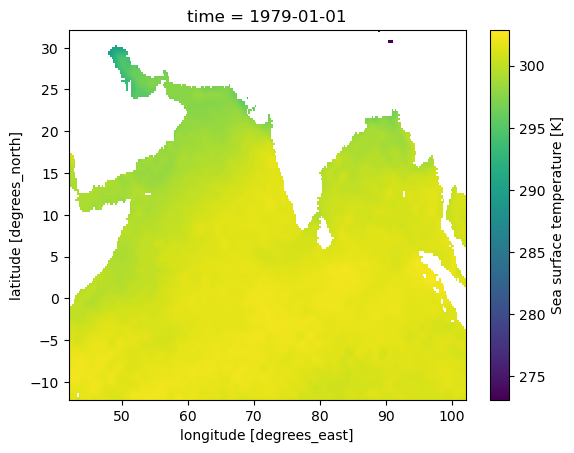

In [4]:
io["sst"].isel(time=0).plot()


In [1]:
from __future__ import annotations
from typing import Optional, Union, Tuple, Dict, Any
import xarray as xr
import numpy as np

In [45]:
### helper functions to normalize coords

def _select_variable(ds: xr.Dataset, var: Union[str, Dict[str, str]]) -> str:
    """
    Pick a variable name from a Dataset.

    If var is a string, it's treated as a variable name.
    If cf_xarray is available and var is a dict, it's used for CF-aware selection
    (e.g., `{"standard_name": "sea_surface_temperature"}`).
    A fallback attempts to match attributes case-insensitively if CF-selection fails.
    """
    if isinstance(var, str):
        if var in ds.data_vars:
            return var
        for k in ds.data_vars:
            if k.lower() == var.lower():
                return k
        raise KeyError(f"Variable '{var}' not found. Available: {list(ds.data_vars)}")

    if _HAS_CF:
        for key in ["standard_name", "long_name", "units"]:
            if key in var:
                matches = ds.cf.select_variables(**{key: var[key]})
                if matches:
                    return list(matches)[0]

    key_order = ["standard_name", "long_name", "units"]
    for candidate in ds.data_vars:
        attrs = {k: str(ds[candidate].attrs.get(k, "")).lower() for k in key_order}
        if any((k in var) and (str(var[k]).lower() == attrs.get(k, "")) for k in key_order):
            return candidate
    raise KeyError(f"Could not locate variable from hints {var}. Variables: {list(ds.data_vars)}")


def _get_coord_names(ds: xr.Dataset) -> Tuple[str, str]:
    """
    Get the longitude and latitude coordinate names from the dataset.
    Supports both long ('longitude', 'latitude') and short ('lon', 'lat') names.
    
    Returns
    -------
    tuple of (lon_name, lat_name)
    """
    lon_name = next((name for name in ['longitude', 'lon'] if name in ds.coords), None)
    lat_name = next((name for name in ['latitude', 'lat'] if name in ds.coords), None)
    
    if not lon_name or not lat_name:
        raise ValueError(f"Could not find longitude/latitude coordinates. Found: {list(ds.coords)}")
    
    return lon_name, lat_name


def _infer_target_lon_frame(lon_min: float, lon_max: float) -> str:
    """
    Infers whether user-provided longitude bounds are in 0-360 or -180-180 frame.
    """
    return "0-360" if (lon_min >= 0 and lon_max <= 360) else "-180-180"


def _coerce_longitudes(ds: xr.Dataset, target_frame: str, assume_frame: Optional[str] = None) -> xr.Dataset:
    """
    Coerce dataset longitudes to a target frame ('0-360' or '-180-180').
    Works with either 'longitude' or 'lon' coordinate names.
    """
    lon_name, _ = _get_coord_names(ds)
    
    lon = ds[lon_name].values
    if assume_frame:
        current = assume_frame
    else:
        current = "0-360" if (np.nanmin(lon) >= 0 and np.nanmax(lon) <= 360) else "-180-180"

    if current == target_frame:
        return ds

    if target_frame == "0-360":
        lon_new = np.mod(lon, 360.0)
    else:  # target is -180-180
        lon_new = ((lon + 180) % 360) - 180
    
    ds = ds.assign_coords({lon_name: lon_new})
    return ds.sortby(lon_name)


def _ensure_lat_monotonic(ds: xr.Dataset) -> xr.Dataset:
    """
    Ensures the latitude coordinate is monotonically increasing.
    Works with either 'latitude' or 'lat' coordinate names.
    """
    _, lat_name = _get_coord_names(ds)
    
    if ds[lat_name].ndim == 1 and ds[lat_name].values[0] > ds[lat_name].values[-1]:
        return ds.sortby(lat_name)
    return ds

#Not currently using
# def _slice_longitude(ds: xr.Dataset, lon_min: float, lon_max: float) -> xr.Dataset:
#     """
#     Slice longitude robustly, handling wrap-around for ranges like 350E to 10E.
#     Works with either 'longitude' or 'lon' coordinate names.
#     """
#     lon_name, _ = _get_coord_names(ds)
    
#     if lon_min <= lon_max:
#         return ds.sel(**{lon_name: slice(lon_min, lon_max)})
    
#     lon = ds[lon_name]
#     part1 = ds.sel(**{lon_name: slice(lon_min, float(lon.max()))})
#     part2 = ds.sel(**{lon_name: slice(float(lon.min()), lon_max)})
#     return xr.concat([part1, part2], dim=lon_name)

In [36]:
def load_climate_data(
    store: Union[str, s3fs.S3Map, fsspec.mapping.FSMap],
    variable: Optional[Union[str, Dict[str, str]]],
    lon_range: Optional[Tuple[float, float]] = None,
    lat_range: Optional[Tuple[float, float]] = None,
    *,
    time_range: Optional[Tuple[str, str]] = None,
    resample_to: Optional[str] = None,
    chunks: Optional[Dict[str, int]] = None,
    storage_options: Optional[Dict[str, Any]] = None,
):
    """
    Load climate data from cloud storage (S3 or GCS) with consistent processing.
    
    Parameters
    ----------
    store : str or s3fs.S3Map or fsspec.mapping.FSMap
        Either a URL string (e.g., "s3://..." or "gs://...") or an existing store object
    variable : str or dict
        Variable name or CF-style selector (e.g., {"standard_name": "air_temperature"})
    lon_range : tuple of float, optional
        (min_longitude, max_longitude) in dataset's native frame. If None, keeps all longitudes.
    lat_range : tuple of float, optional
        (min_latitude, max_latitude). If None, keeps all latitudes.
    time_range : tuple of str, optional
        (start_date, end_date) as ISO strings. If None, keeps all times.
    convert_kelvin_to_celsius : bool, default True
        If True, convert temperature data from Kelvin to Celsius
    resample_to : str, optional
        If provided, resample time dimension (e.g., "MS" for month start)
    chunks : dict, optional
        Dask chunks specification (e.g., {"time": 1024})
    storage_options : dict, optional
        Only used if store is a string URL. Additional storage options for cloud access.
        
    Returns
    -------
    xr.Dataset
        Processed dataset with consistent dimensions
    """
    
    # Open dataset
    if isinstance(store, str):
        # If store is a URL string, use storage_options
        ds = xr.open_dataset(
            store,
            engine="zarr",
            chunks=chunks,
            backend_kwargs={"storage_options": storage_options},
        )
    else:
        # If store is already an FSMap object, use it directly
        ds = xr.open_zarr(store, chunks=chunks)
    
    # Get coordinate names
    lon_name, lat_name = _get_coord_names(ds)
    
    # Subset space and time
    region = {}
    if lon_range is not None and lat_range is not None:
        region.update({
            lon_name: slice(*lon_range),
            lat_name: slice(*lat_range)
        })
    if time_range is not None:
        region["time"] = slice(*time_range)
    
    # Only apply selection if we have regions to subset
    if region:
        ds = ds.sel(**region)
    
    # Handle longitude frame and monotonic latitude
    if lon_range is not None:
        target_frame = _infer_target_lon_frame(*lon_range)
        ds = _coerce_longitudes(ds, target_frame)
    ds = _ensure_lat_monotonic(ds)
    
    # Optional time resampling
    if resample_to:
        ds = ds.resample(time=resample_to).mean()
    
    # Ensure consistent dimension order
    # Get available dimensions
    dims = list(ds.dims)
    # Core dims we want first (if they exist)
    core_dims = ["time", "latitude", "longitude"]
    # Filter out core dims that actually exist
    core_dims = [d for d in core_dims if d in dims]
    # Add any remaining dims at the end
    other_dims = [d for d in dims if d not in core_dims]
    # Combine for final ordering
    final_dims = core_dims + other_dims
    
    ds = ds.transpose(*final_dims)

    if variable:
        var = _select_variable(ds, variable)
        ds = ds[var]
    
    return ds

In [44]:
# Create the store
store = s3fs.S3Map(
    root="s3://mur-sst/zarr-v1/",
    s3=s3,
    check=False
)

# Use it with the function
sst_data = load_climate_data(
    store=store,
    variable = None,
    lon_range=(0, 60),
    lat_range=(-20, 20)
)

sst_data

<xarray.Dataset> Size: 4TB
Dimensions:           (time: 6443, lat: 4001, lon: 6001)
Coordinates:
  * lat               (lat) float32 16kB -20.0 -19.99 -19.98 ... 19.99 20.0
  * lon               (lon) float32 24kB 0.0 0.01 0.02 0.03 ... 59.98 59.99 60.0
  * time              (time) datetime64[ns] 52kB 2002-06-01T09:00:00 ... 2020...
Data variables:
    analysed_sst      (time, lat, lon) float64 1TB ...
    analysis_error    (time, lat, lon) float64 1TB ...
    mask              (time, lat, lon) float32 619GB ...
    sea_ice_fraction  (time, lat, lon) float64 1TB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [41]:
chl_data = load_climate_data(
    store="gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    variable=None,
    time_range=("2020-01-01", "2020-03-31"),
    resample_to="MS",)

chl_data

<xarray.Dataset> Size: 14MB
Dimensions:                       (time: 3, lat: 177, lon: 241)
Coordinates:
  * lat                           (lat) float32 708B -12.0 -11.75 ... 31.75 32.0
  * lon                           (lon) float32 964B 42.0 42.25 ... 101.8 102.0
  * time                          (time) datetime64[ns] 24B 2020-01-01 ... 20...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 512kB nan nan ... nan
    CHL_cmes-cloud                (time, lat, lon) float64 1MB 2.0 2.0 ... 2.0
    CHL_cmes-gapfree              (time, lat, lon) float32 512kB nan nan ... nan
    CHL_cmes-level3               (time, lat, lon) float32 512kB nan nan ... nan
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 512kB nan nan ... nan
    CHL_cmes_flags-level3         (time, lat, lon) float32 512kB nan nan ... nan
    ...                            ...
    v_wind                        (time, lat, lon) float32 512kB -3.804 ... 0...
    vg_curr                       (time, lat, lon) float32 512kB -0.1609 ... nan
    wind_dir                      (time, lat, lon) float32 512kB -65.01 ... 6...
    wind_speed                    (time, lat, lon) float32 512kB 4.731 ... 0....
    CHL_cmes-land                 (time, lat, lon) uint8 128kB 2 2 2 2 ... 2 2 2
    topo                          (time, lat, lon) float64 1MB -2.658e+03 ......
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

In [43]:
era5_data = load_climate_data(
    store="gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr",
    variable=None,
    lon_range=(0, 90),    
    lat_range=(-20, 60),  
    time_range=("2020-01-01", "2020-12-31"),
    resample_to="MS",     
    chunks={"time": 1024})

era5_data

<xarray.Dataset> Size: 38MB
Dimensions:                                           (time: 12, longitude: 61,
                                                       latitude: 54, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 432B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 488B ...
  * time                                              (time) datetime64[ns] 96B ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    above_ground                                      (time, latitude, longitude, level) float32 2MB dask.array<chunksize=(12, 54, 61, 13), meta=np.ndarray>
    ...                                                ...
    slope_of_sub_gridscale_orography                  (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    soil_type                                         (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    standard_deviation_of_filtered_subgrid_orography  (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    standard_deviation_of_orography                   (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    type_of_high_vegetation                           (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>
    type_of_low_vegetation                            (time, latitude, longitude) float32 158kB dask.array<chunksize=(12, 54, 61), meta=np.ndarray>